In [66]:
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [67]:
class Lobo(Agent):
    # Agentes que se comen a las ovejas.
    def __init__(self, unique_id, pos,e,model):
        # la clase agente guarda los ids y los enlaza con el modelo 
        super().__init__(unique_id,model)
        # lobos tienen energia, una posicion y una probabilidad de reproducirse
        self.energia = e 
        self.pos = pos
    
    def move(self):
        # get_neighbourhood es utilidad de mesa pa devolver los vecinos
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=False,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
        
    def step(self):
        self.move()
         
        # comerse alguna oveja que este en su grilla 
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        sheep = [obj for obj in cellmates if isinstance(obj, Oveja)]
        if len(sheep)>0: 
            victima = self.random.choice(sheep)
            self.model.grid._remove_agent(self.pos, victima)
            self.model.schedule.remove(victima)
            self.energia += 10
            
        #si no tengo energia, muero 
        self.energia -= 1
        if self.energia < 1: 
            self.model.grid._remove_agent(self.pos, self)
            self.model.schedule.remove(self)
            return

In [68]:
class Oveja(Agent):
    def __init__(self, unique_id,pos,e,prob_rep, model):
        super().__init__(unique_id, model)
        self.pos = pos
        self.energia = e 
        self.prob_rep = prob_rep

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=False,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
        
    def step(self):
        self.move()
        
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        pasto = [obj for obj in cellmates if isinstance(obj, Pasto)]
        if len(pasto)>0: 
            comida = self.random.choice(pasto)
            self.model.grid._remove_agent(self.pos, comida)
            self.model.schedule.remove(comida)
            self.energia += 10
            
        #tener hijos
        if self.model.random.randint(1,10) < self.prob_rep:  #probabilidad de reproducirse 
            self.energia /= 2
            hija = Oveja(self.model.next_id(),self.pos,self.energia,self.prob_rep,self.model)
            self.model.grid.place_agent(hija, hija.pos)
            self.model.schedule.add(hija)
            
        self.energia -= 1
        if self.energia < 1: 
            self.model.grid._remove_agent(self.pos, self)
            self.model.schedule.remove(self)
            return

In [69]:
class Pasto(Agent):
    def __init__(self,unique_id,pos,model):
        super().__init__(unique_id,model)
        self.pos = pos

In [81]:
class Lobooveja(Model):
    def __init__(self, N, M, O, width, height,prob_lobos,prob_pasto,p_rep_o):
        self.num_lobos = N
        self.num_ovejas = M
        self.num_pastos = O
        self.prob_lobos = prob_lobos
        self.prob_pasto = prob_pasto
        self.p_rep_o = p_rep_o
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.current_id = 0
        
        # Crear lobos
        for i in range(self.num_lobos):
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            l = Lobo(self.next_id(),(x,y),15,self) # 15 es la energía 
            self.schedule.add(l)
            # Add the agent to a random grid cell
            self.grid.place_agent(l, (x, y))
            
        # Crear ovejas
        for i in range(self.num_ovejas):
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            o = Oveja(self.next_id(),(x,y),15,self.p_rep_o,self) # 15 es la energía
            self.schedule.add(o)
            # Add the agent to a random grid cell
            self.grid.place_agent(o, (x, y)) 
    
        # Crear pasto
        for i in range(self.num_pastos):
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            p = Pasto(self.next_id(),(x,y),self)
            self.schedule.add(p)
            self.grid.place_agent(p, (x, y))
            
    def step(self):
        self.schedule.step()
  
    
    def create(self):
        if np.random.randint(1,10) < self.prob_lobos:
            for i in range(3):
                x = self.random.randrange(self.grid.width)
                y = self.random.randrange(self.grid.height)
                l = Lobo(self.next_id(),(x,y),15,self)
                self.schedule.add(l)
                self.grid.place_agent(l, (x, y))
        
        if np.random.randint(1,10) < self.prob_pasto:
            for i in range(5):
                x = self.random.randrange(self.grid.width)
                y = self.random.randrange(self.grid.height)
                p = Pasto(self.next_id(),(x,y),self)
                self.schedule.add(p)   
                self.grid.place_agent(p, (x, y))

In [91]:
T = 400 #horizonte temporal
N = 30 # número de lobos
M = 10 # número de ovejas 
O = 200

#tamaño de la grilla
width = 10  
height = 10 

ovejas = []
lobos = []

for j in range(4): #4 modelos distintos 
    ovejas.append([])
    lobos.append([])
    model = Lobooveja(N,M,O,width, height,1,6,5)
    for i in range(T):
        model.step()
        model.create()
        ovejas[j].append(0)
        lobos[j].append(0)
        for a in model.schedule.agents:
            if isinstance(a,Oveja): 
                ovejas[j][i]+=1
            elif isinstance(a,Lobo):
                lobos[j][i]+=1

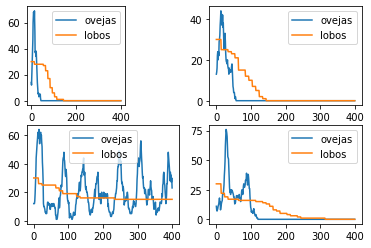

In [92]:
plt.subplot(2,3,1)
plt.plot(ovejas[0], label = "ovejas")
plt.plot(lobos[0], label = "lobos")
plt.legend()

plt.subplot(2,2,2)
plt.plot(ovejas[1], label = "ovejas")
plt.plot(lobos[1], label = "lobos")
plt.legend()

plt.subplot(2,2,3)
plt.plot(ovejas[2], label = "ovejas")
plt.plot(lobos[2], label = "lobos")
plt.legend()

plt.subplot(2,2,4)
plt.plot(ovejas[3], label = "ovejas")
plt.plot(lobos[3], label = "lobos")
plt.legend()